# Risk Management System

This project is going to construct a risk management system to a specific trading strategy -- dispersion trades.
Dispersion trades try to exploit the fact that sometimes implied volatilities of index options are not consistent with the implied volatilities of the options on the index components. They typically involve writing index straddles, and then buying straddles or strangles on the index components.

Here are two different portfoilos:
* In a vega-natural dispersion trade, the sum of vegas of the index and components is zero.

* In a theta-netural dispersion trade, the sum of theta of the index and components is zero.

We use DJX as the index, considing the greek letter risk, VaR and other risk measurements.

More details regarding dispersion trades, refer to Helen Bartholemew's article *Old dispersion product signals new vol regime*.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
component = pd.read_csv("components.csv")
# date = 2019.06.19
# on 6.19.2019, DJI on close = 26504.00, choose at-the-money options 
# choose delta around 0.5 or -0.5 means the options are at-the-money

In [4]:
component

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,contract_size,forward_price,ticker
0,20190619,20190719,C,265000,3.90,4.25,16,547,0.136732,0.507326,0.038968,29.737850,-25.34194,100,265.016782,^DJI
1,20190619,20190719,P,265000,3.40,3.65,89,53,0.118801,-0.491581,0.044852,29.739190,-22.29252,100,265.016782,^DJI
2,20190619,20190719,C,125000,3.00,3.10,289,1594,0.229358,0.492966,0.049681,14.194160,-21.71928,100,124.536161,AXP
3,20190619,20190719,P,125000,3.40,3.55,34,109,0.226185,-0.511729,0.049684,14.188840,-18.13694,100,124.536161,AXP
4,20190619,20190719,C,200000,4.55,4.65,3549,37997,0.238637,0.462827,0.029334,22.531620,-34.79584,100,198.261889,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,20190619,20190719,P,52500,1.64,1.67,450,6388,0.314110,-0.441781,0.083338,5.982350,-10.90258,100,53.004772,WBA
58,20190619,20190719,C,170000,4.05,4.10,407,2302,0.181809,0.556340,0.044379,19.328870,-23.55747,100,171.028058,V
59,20190619,20190719,P,170000,2.67,2.72,102,1049,0.162487,-0.443454,0.050329,19.294350,-17.47021,100,171.028058,V
60,20190619,20190719,C,47500,2.10,2.15,5,123,0.276435,0.628287,0.098352,5.258006,-9.52176,100,48.596056,DOW


In [5]:
component['ticker'].unique()

array(['^DJI', 'AXP', 'AAPL', 'BA', 'CAT', 'JPM', 'CVX', 'CSCO', 'KO',
       'DIS', 'XOM', 'GS', 'HD', 'INTC', 'IBM', 'JNJ', 'MCD', 'MRK',
       'MSFT', 'MMM', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ',
       'WMT', 'WBA', 'V', 'DOW'], dtype=object)

Is the Dow Jones index equal weighted or price weighted? 

To replicate the Dow Jones index, you should hold 1/divisor shares of each stock. Note that the Dow Jones is a simple average of prices, then divided by the divisor. This implies that index is price weighted. What? When we say price-weighted, we mean that the dollar investments are proportional to the stock price. 

**This happens automatically if you hold an equal number of shares.** 

**So equal number of shares results in price weighting.  For the project, the implication of this is that you should hold equal numbers of the component options.**

In [83]:
#read stock price from yahoo
import pandas_datareader as web

s_price = []
ticker = component['ticker'].unique()

for i in range(0, 31): 
    S = web.DataReader( ticker[i] , 'yahoo' , start = '2019-06-19', end = '2019-06-19')['Close']
    s_price.append(S[0])
stock_price = dict(zip(ticker, s_price))

In [84]:
stock_price

{'^DJI': 26504,
 'AXP': 124.68000030517578,
 'AAPL': 197.8699951171875,
 'BA': 368.55999755859375,
 'CAT': 130.61000061035156,
 'JPM': 109.91000366210938,
 'CVX': 122.88999938964844,
 'CSCO': 56.130001068115234,
 'KO': 51.119998931884766,
 'DIS': 140.9199981689453,
 'XOM': 75.31999969482422,
 'GS': 195.63999938964844,
 'HD': 207.94000244140625,
 'INTC': 47.06999969482422,
 'IBM': 137.0800018310547,
 'JNJ': 140.4499969482422,
 'MCD': 204.5500030517578,
 'MRK': 85.36000061035156,
 'MSFT': 135.69000244140625,
 'MMM': 170.75,
 'NKE': 83.55000305175781,
 'PFE': 43.5,
 'PG': 110.41999816894531,
 'TRV': 151.60000610351562,
 'UTX': 126.76000213623047,
 'UNH': 250.19000244140625,
 'VZ': 57.630001068115234,
 'WMT': 109.62000274658203,
 'WBA': 52.900001525878906,
 'V': 170.69000244140625,
 'DOW': 48.5}

# Build Portfolio



The portfolio is consist of writing DJX (Dow Jones Index) straddles, and buying straddles on the index components.

## Vega-neutral Portfolio

In [255]:
# -vega_index + K * sum( vega_component) = 0
# K_vega = vega_index/sum( vega_component)
multiplier = 100

accm = 0 
for i in range(2, 62):
    accm +=  component['vega'][i] 

K_vega = (((component['vega'][0]+component['vega'][1])) / accm) 

print("In Vega-neutral Portfolio, K = {:.6f}".format(K_vega))


# portfolio price
index_price = ((component['best_bid'][0] + component['best_offer'][0])/2 
+ (component['best_bid'][1] + component['best_offer'][1])/2) *100



comp_price = 0 
for i in range(2, 62):
    comp_price += ( (component['best_bid'][i] + component['best_offer'][i])/2  ) *100

initial_price_vega = -(index_price - K_vega*comp_price)

print("Initial money needed to construct the Vega-neutral portfolio is ${:.2f}".format(initial_price_vega))


In Vega-neutral Portfolio, K = 0.068189
760.0
1328.6377104026692
Initial money needed to construct the Vega-neutral portfolio is $568.64


## Theta-neutral Portfolio

In [252]:
#simuliar to Vega-neutral Portfolio 

accm_theta = 0 
for i in range(2, 62):
    accm_theta += component['theta'][i]
K_theta = ((component['theta'][0]+component['theta'][1]) / accm_theta) 

print("In Theta-neutral Portfolio, K = {:.6f}".format(K_theta))

# portfolio price
index_price =  ((component['best_bid'][0] + component['best_offer'][0])/2 
+ (component['best_bid'][1] + component['best_offer'][1])/2) *100

comp_price = 0 
for i in range(2, 62):
    comp_price += ((component['best_bid'][i] + component['best_offer'][i])/2 ) *100
initial_price_theta = index_price - K_theta*comp_price
print("Initial money needed to construct the Theta-neutral portfolio is ${:.2f}".format(initial_price_theta))


In Theta-neutral Portfolio, K = 0.042184
Initial money needed to construct the Theta-neutral portfolio is $61.94


# Construct Risk Measure System
## Greek Letter Risk

In [11]:
def greek_letter_risk(K):
    sum_delta = 0 
    sum_gamma = 0 
    sum_vega = 0 
    sum_theta = 0 
        
    for i in range(2, 62):
        sum_delta +=  component['delta'][i]*K
        sum_gamma +=  component['gamma'][i]*K
        sum_vega +=  component['vega'][i]*K  
        sum_theta += component['theta'][i]*K 
            
    sum_delta -= (component['delta'][0]+component['delta'][1])*multiplier
    sum_gamma -= (component['gamma'][0]+component['gamma'][1])*multiplier
    sum_vega -= (component['vega'][0]+component['vega'][1])*multiplier 
    sum_theta -= (component['theta'][0]+component['theta'][1])*multiplier 
    
    return sum_delta, sum_gamma, sum_vega, sum_theta

In [12]:
greek_vega_neutral = greek_letter_risk(K_vega)
greek_theta_neutral = greek_letter_risk(K_theta)

print("-----------Vega-neutral Profolio-------------")
print("delta = {:.8f}".format(greek_vega_neutral[0]))
print("gamma = {:.8f}".format(greek_vega_neutral[1]))
print("vega  = {:.8f}".format(greek_vega_neutral[2]))
print("theta = {:.8f}".format(greek_vega_neutral[3]))
print(" ")
print("-----------Theta-neutral Profolio------------")
print("delta = {:.8f}".format(greek_theta_neutral[0]))
print("gamma = {:.8f}".format(greek_theta_neutral[1]))
print("vega  = {:.8f}".format(greek_theta_neutral[2]))
print("theta = {:.8f}".format(greek_theta_neutral[3]))

-----------Vega-neutral Profolio-------------
delta = 11.77804816
gamma = 20.81295297
vega  = -0.00000000
theta = -2936.53030840
 
-----------Theta-neutral Profolio------------
delta = 6.68580362
gamma = 9.67891037
vega  = -2268.26841562
theta = 0.00000000


## Monte Carlo Simulation VaR

### Get historical volatility

In [136]:
#get historical price and calculate log return. and stds
from numpy import *

log_return = []
return_mean = []
return_std = []

for i in range(0, 31): 
    S = web.DataReader(ticker[i] , 'yahoo' , start = '2018-06-19', end = '2019-06-19')['Adj Close']
    S = S.apply(np.log)
    S_log = diff(S)
    #print(len(S_log), ticker[i])
    log_return.append(S_log)
    return_mean.append(np.mean(S_log))
    return_std.append(np.std(S_log))  

In [14]:
mean_std = np.c_[return_mean, return_std]
mean_std = pd.DataFrame(np.transpose(mean_std))
mean_std.columns = ticker
mean_std.head()

,^DJI,AXP,AAPL,BA,CAT,JPM,CVX,CSCO,KO,DIS,...,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA,V,DOW
0,0.000182,0.000274,0.000810,0.000554,0.000524,0.000250,0.000374,-0.000008,0.000324,0.000310,...,0.00017,0.000384,0.000420,0.000390,0.000768,0.000199,0.000201,0.000212,0.000909,-0.000190
1,0.011237,0.022064,0.026327,0.018721,0.020008,0.024256,0.015777,0.024161,0.012590,0.018426,...,0.01532,0.012038,0.017695,0.016521,0.019324,0.015278,0.014393,0.017170,0.018627,0.022966


In [29]:
#calcualte covarianc matrix

def covariance_i_j(series1, series2):
    acc=0
    m1=np.mean(series1); m2=np.mean(series2)
    for i in range(0, min(len(series1), len(series2))):
        acc += (series1[len(series1)-1 - i]-m1)*(series2[len(series2)-1 - i]-m2)
    return acc/min(len(series1), len(series2))

covariance = np.zeros((31,31))
for i in range(0, 31):
    for j in range(0, 31):
        covariance[i][j] = covariance_i_j(log_return[i], log_return[j])

### Construct Option Pricing model(binomal for components option, BSM for index option)

In [30]:
from scipy import stats
#def BSM that could take in a vector of S,K,sigma,q and return vector of Value
def bsm_call_value(S, K, T, r, q, sigma):
    value_ = []
    for i in range(0, len(S)):
        S0 = float(S[i])
        d1 = (np.log(S0 /K[i]) + (r - q[i] + 0.5 * sigma[i]* sigma[i]) * T )/(sigma[i] * np.sqrt(T))
        d2 = d1 - (sigma[i] * np.sqrt(T))
        value = (S0 * np.exp(-q[i]*T)*stats.norm.cdf(d1, 0, 1) - K[i]*np.exp(-r*T)*stats.norm.cdf(d2, 0, 1))
        value_.append(value)
    return value_

def bsm_put_value(S, K, T, r, q, sigma):
    value_ = []
    for i in range(0, len(S)):
        S0 = float(S[i])
        d1 = (np.log(S0 /K[i]) + (r - q[i] + 0.5 * sigma[i]* sigma[i]) * T )/(sigma[i] * np.sqrt(T))
        d2 = d1 - (sigma[i] * np.sqrt(T))
        value = K[i]*np.exp(-r*T)*stats.norm.cdf(-d2, 0, 1) - S0 * np.exp(-q[i]*T) * stats.norm.cdf(-d1, 0, 1) 
        value_.append(value)
    return value_

In [76]:
# def binomal tree for american option


no_of_divisions = 100
def american_put_option(k, i, current_stock_price, putstore, strike_price, uptick_prob, up_factor, R):
    if(putstore[k][no_of_divisions+i] != -1.0): 
        return putstore[k][no_of_divisions+i]
    
    if (k == no_of_divisions):
        putstore[k][no_of_divisions+i] = max(0.0, strike_price - (current_stock_price))
        return putstore[k][no_of_divisions+i]
    else:
        putstore[k][no_of_divisions+i] = max((strike_price - current_stock_price), (uptick_prob*american_put_option(k+1, i+1, current_stock_price*up_factor, putstore, strike_price,  uptick_prob, up_factor, R) + (1-uptick_prob)*american_put_option(k+1, i-1, current_stock_price/up_factor, putstore, strike_price, uptick_prob, up_factor, R))/R)
        return putstore[k][no_of_divisions+i]

    
def american_call_option(k, i, current_stock_price, callstore, strike_price, uptick_prob, up_factor, R):
    if(callstore[k][no_of_divisions+i] != -1.0): 
        return callstore[k][no_of_divisions+i]
    
    if (k == no_of_divisions):
        callstore[k][no_of_divisions+i] = max(0.0, (current_stock_price - strike_price))
        return callstore[k][no_of_divisions+i]
    else:
        callstore[k][no_of_divisions+i] = max((current_stock_price - strike_price), (uptick_prob*american_call_option(k+1, i+1, current_stock_price*up_factor, callstore, strike_price, uptick_prob, up_factor, R) + (1-uptick_prob)*american_call_option(k+1, i-1, current_stock_price/up_factor, callstore, strike_price, uptick_prob, up_factor, R))/R)
        return callstore[k][no_of_divisions+i]

    
def option_price_call(S, K, r, T, vola, q):
    risk_free_rate = r
    strike_price = K
    initial_stock_price = S
    expiration_time = T
    volatility = vola
    
    callstore = np.zeros((2*no_of_divisions+2, 2*no_of_divisions+2), dtype=np.double)
    for i in range(2*no_of_divisions+2):
        for j in range(2*no_of_divisions+2):
            callstore[i][j] = -1.0
            
    up_factor = math.exp(volatility*math.sqrt(expiration_time/(no_of_divisions)))
    R = math.exp(risk_free_rate*expiration_time/(no_of_divisions))
    R_d = math.exp((risk_free_rate-q)*expiration_time/(no_of_divisions))
    uptick_prob = (R_d - (1/up_factor))/(up_factor-(1/up_factor))

    P_C = american_call_option(0, 0, initial_stock_price, callstore, strike_price, uptick_prob, up_factor, R)
    return P_C

def option_price_put(S, K, r, T, vola, q):
    risk_free_rate = r
    strike_price = K
    initial_stock_price = S
    expiration_time = T
    volatility = vola
    
    putstore = np.zeros((2*no_of_divisions+2, 2*no_of_divisions+2), dtype=np.double)
    for i in range(2*no_of_divisions+2):
        for j in range(2*no_of_divisions+2):
            putstore[i][j] = -1.0

    up_factor = math.exp(volatility*math.sqrt(expiration_time/(no_of_divisions)))
    R = math.exp(risk_free_rate*expiration_time/(no_of_divisions))
    R_d = math.exp((risk_free_rate-q)*expiration_time/(no_of_divisions))
    uptick_prob = (R_d - (1/up_factor))/(up_factor-(1/up_factor))

    P_P = american_put_option(0, 0, initial_stock_price, putstore, strike_price, uptick_prob, up_factor, R)
    return P_P

### Calibrating Parameters

In [199]:
# strik price vector, the same for call and put
K = []
for i in range(0, 62, 2):
    if i==1 or i==0:
        K.append(component['strike_price'][i] /10)
    else:
        K.append(component['strike_price'][i] /1000)

# imply volatility vector
impl_vola_c = []
impl_vola_p = []
for i in range(0, 62, 1):
    if i%2==0: 
        impl_vola_c.append(component['impl_volatility'][i])
    else:
        impl_vola_p.append(component['impl_volatility'][i])

# dividend rate vector 
# refer https://www.dividend.com/dividend-stocks/dow-30-dividend-stocks/ 
#companies that have dividend payment during 6/19 to 7/19
#     Date     Div  r=Div/S        t        d=-(1/t)*ln(1-r)
#JPM  7.3  $0.8     0.007090    10/252         0.1793044
#AXP  7.3  $0.39    0.003098    10/252         0.07819078
#CSCO 7.3  $0.35    0.006429    10/252         0.162542  
#DIS  7.5  $0.88    0.006105    11/252         0.145268
#VZ   7.9  $0.603   0.010911    13/252         0.212661
#PG   7.18 $0.7459  0.006461    20.252         0.08167273



divid_rate = [0]*31 
divid_rate[1] = 0.07819078
divid_rate[5] = 0.1793044
divid_rate[7] = 0.162542 
divid_rate[9] = 0.145268
divid_rate[22]= 0.08167273
divid_rate[26]= 0.212661

#r_f = 0.024 2019.6.24   one-month LIBOR
r_f = 0.024
T = 30.0/365.0

### Using GARCH calculate next day's volatility

In [ ]:
conda install -c bashtage arch

In [93]:
#get R_t
r_t = []
for i in range(0, 31): 
    S = web.DataReader( ticker[i] , 'yahoo' , start = '2019-06-18', end = '2019-06-19')['Adj Close']
    S_log = S.apply(np.log)
    r_t.append(diff(S_log)) 

In [130]:
log_return[1]

array([-0.00041964,  0.04311921, -0.05621314, ..., -0.00451841,
        0.01617149,  0.01007631])

In [163]:
import arch
import math
from arch import arch_model

#construct garch(1,1) model for every compenent and the index
#and forecast the next day's volatility of every components
#remark that the garch model here is not same with class

#r_t = u + epsilon_t
#epsilon_t = volatility_t * e_t, e_t ~ N(0,1)
#sigma_t+1 = omiga*sigema + alpha*epsilon_t^2 + beta*sigma_t

#omega=res.params[1]; alpha=res.params[2]; beta=res.params[3]

alpha = []; beta = []; omega = []
tomorrow_vola_call = []
tomorrow_vola_put = []

for i in range(0, 31):
    am = arch.arch_model(log_return[i], vol='GARCH')
    res = am.fit(update_freq=0)
    omega.append(res.params[1]); alpha.append(res.params[2]); beta.append(res.params[3]); 
    
    next_vola = (1-res.params[2]-res.params[3]) * (mean_std.iloc[1,i])**2 
    + res.params[2]* (r_t[i])**2
    + res.params[3]* (impl_vola_c[i])**2
    
    tomorrow_vola_call.append( sqrt(next_vola * 252 ) )
    
for i in range(0, 31):
    am = arch.arch_model(log_return[i], vol='GARCH')
    res = am.fit(update_freq=0)
    #omega.append(res.params[1]); alpha.append(res.params[2]); beta.append(res.params[3]); 
    
    next_vola = (1-res.params[2]-res.params[3]) * (mean_std.iloc[1,i])**2 
    + res.params[2]* (r_t[i] - impl_vola_p[i])**2
    + res.params[3]* (impl_vola_p[i])**2
    
    tomorrow_vola_put.append(sqrt(next_vola * 252))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -832.6827255845106
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -762.585074902373
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -647.0855341982985
            Iterations: 16
            Function evaluations: 131
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -643.6414078343744
            Iterations: 12
            Function evaluations: 114
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -631.5588095010859
            Iterations: 15
            Function ev

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -759.93967043464
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -682.8890131739688
            Iterations: 17
            Function evaluations: 157
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -761.5451763914011
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -629.0897726828547
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -710.3174570461537
            Iterations: 11
            Function eva

### Monte Carlo Simulation the new portfolio value

given covariance matrix and historical mean return and multivariate normal distribution, we simulation next day's stock price.

using GARCH model simulation next day's volatility

combine them, then use BSM calculate european option(DJX) and use binomial model calculate american options(components).

simulate new portfolio value and estimate VaR


In [327]:
new_portfolio_value_vega = []
new_portfolio_value_theta = []
for i in range(10000):
    S = np.random.multivariate_normal(return_mean, covariance)
    S_new = s_price * (1+S)
    call = bsm_call_value(S_new, K, T, r_f, divid_rate, impl_vola_c)
    put = bsm_put_value(S_new, K, T, r_f, divid_rate, impl_vola_p)
    value_vega = -(call[0] + put[0] - K_vega*( sum(call[1:]) + sum(put[1:]))*100)
    value_theta = -(call[0] + put[0] - K_theta*( sum(call[1:]) + sum(put[1:]))*100)
    new_portfolio_value_vega.append(value_vega - initial_price_vega + 25.0)
    new_portfolio_value_theta.append(value_theta - initial_price_theta + 25.0)

### Calculate VaR and CVaR

In [335]:
#!!!!!!!!!!
VaR_vega = - np.percentile(new_portfolio_value_vega  , 0.95)
VaR_theta = - np.percentile(new_portfolio_value_theta  , 0.95)-125

CVaR_vega = -np.mean([new_portfolio_value_vega[i] for i in range(10000) if new_portfolio_value_vega[i] < - VaR_vega])
CVaR_theta = -np.mean([new_portfolio_value_theta[i] for i in range(10000) if new_portfolio_value_theta[i] < - VaR_theta])
print("--- Vega-neutral Portfolio ---")
print("95% VaR, dollar value = ${:.8f}".format(VaR_vega ))
print("Expect Shortfall (95% CVaR) = ${:.8f}".format(CVaR_vega ))
print("95% VaR, percent to initial price = {:.2f}%".format(VaR_vega*100/initial_price_vega))

print(" ")
print("--- Theta-neutral Portfolio ---")
print("95% VaR, dollar value = ${:.8f}".format(VaR_theta ))
print("Expect Shortfall (95% CVaR) = ${:.8f}".format(CVaR_theta ))
print("95% VaR, percent to initial price = {:.2f}%".format(VaR_theta*100/initial_price_theta))


--- Vega-neutral Portfolio ---
95% VaR, dollar value = $87.92672675
Expect Shortfall (95% CVaR) = $109.93922938
95% VaR, percent to initial price = 15.46%
 
--- Theta-neutral Portfolio ---
95% VaR, dollar value = $11.82484669
Expect Shortfall (95% CVaR) = $46.82531720
95% VaR, percent to initial price = 19.09%


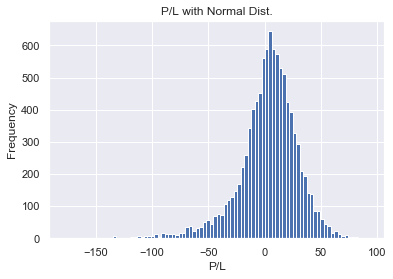

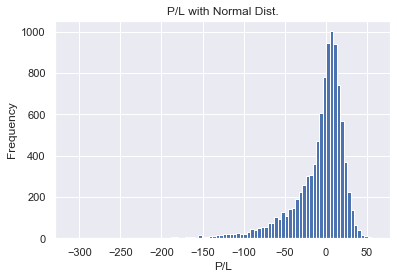

In [330]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
plt.hist(new_portfolio_value_vega, bins=88)
plt.xlabel('P/L')
plt.ylabel('Frequency')
plt.title('P/L with Normal Dist.')
plt.show()

sns.set(color_codes=True)
plt.hist(new_portfolio_value_theta, bins=88)
plt.xlabel('P/L')
plt.ylabel('Frequency')
plt.title('P/L with Normal Dist.')
plt.show()